In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, PauliFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

algorithm_globals.random_seed = 12345

/var/folders/3x/sg00y37n2rg22srjzxtsqjqw0000gn/T/ipykernel_58466/2977014002.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


/Users/temitopeadeniyi/opt/anaconda3/envs/tensorflow_m1/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


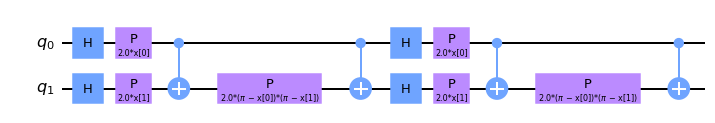

In [2]:
feature_map = PauliFeatureMap(2)
feature_map.decompose().draw("mpl")

/Users/temitopeadeniyi/opt/anaconda3/envs/tensorflow_m1/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


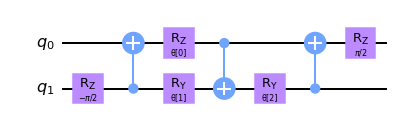

In [3]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

In [4]:
from qiskit.visualization import circuit_drawer

In [5]:
from qiskit.visualization import matplotlib
#matplotlib.use('Agg')  # To save the circuit as a PNG without displaying it

# Define your circuit
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)

# Create a matplotlib figure for the circuit
fig = circuit_drawer(circuit, output="mpl")

# Save the figure as a PNG file
fig.savefig("conv_circuit.png", format="png")

# Clean up the matplotlib figure
plt.close(fig)

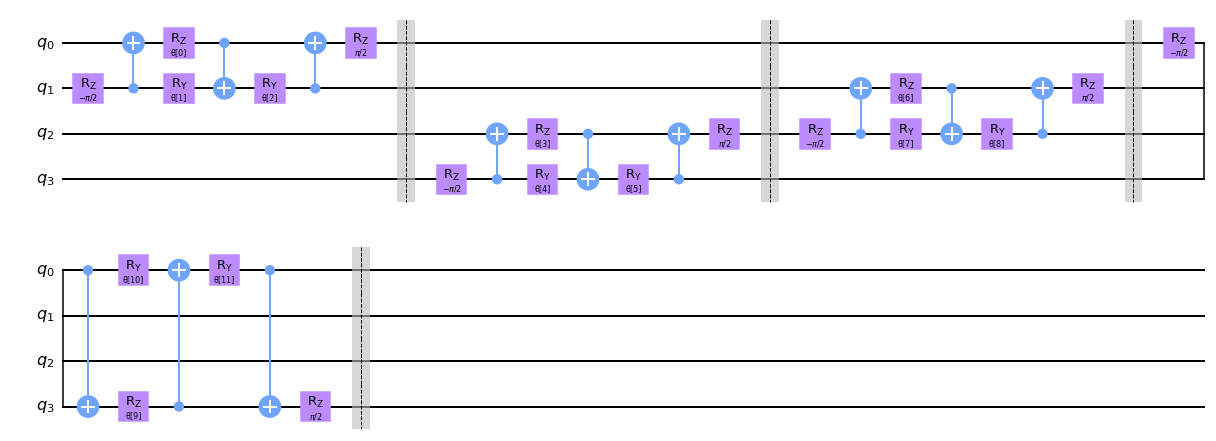

In [6]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

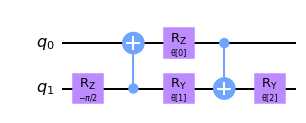

In [7]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

In [8]:
from qiskit.visualization import matplotlib
#matplotlib.use('Agg')  # To save the circuit as a PNG without displaying it

# Define your circuit
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)

# Create a matplotlib figure for the circuit
fig = circuit_drawer(circuit, output="mpl")

# Save the figure as a PNG file
fig.savefig("pooling_circuit.png", format="png")

# Clean up the matplotlib figure
plt.close(fig)

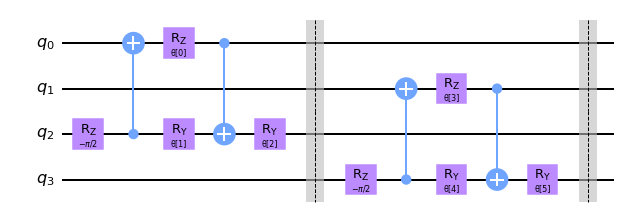

In [9]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [10]:
# Load MNIST dataset
DATA_PATH = 'pneumoniamnist.npz'
data = np.load(DATA_PATH)

sample_train = data['train_images']
labels_train = data['train_labels']
sample_test = data['test_images']

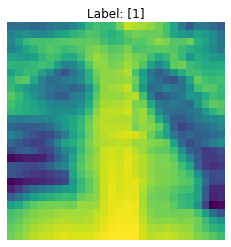

In [11]:
# Select a single sample (e.g., the first one)
single_sample = sample_train[1]

# Display the image using matplotlib
plt.imshow(single_sample)
plt.title(f'Label: {labels_train[0]}')  # Display the corresponding label
plt.axis('off')  # Turn off axis labels
plt.show()

In [32]:
sample_train.shape

(3500, 28, 28)

In [13]:
sample_test.shape

(624, 28, 28)

In [33]:
num_samples, num_rows, num_cols = sample_train.shape
sample_train = sample_train.reshape(num_samples, -1)

In [34]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)


# Reduce dimensions
N_DIM = 8
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)


# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)

In [35]:
train_images, test_images, train_labels, test_labels = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42
)

In [36]:
print("Image data shape:", train_images[0].shape)

Image data shape: (8,)


/Users/temitopeadeniyi/opt/anaconda3/envs/tensorflow_m1/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


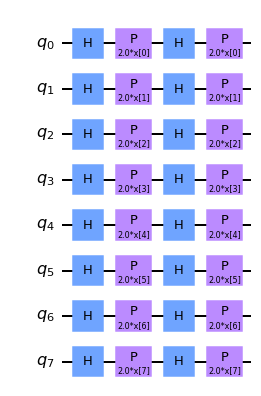

In [37]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl")

In [38]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

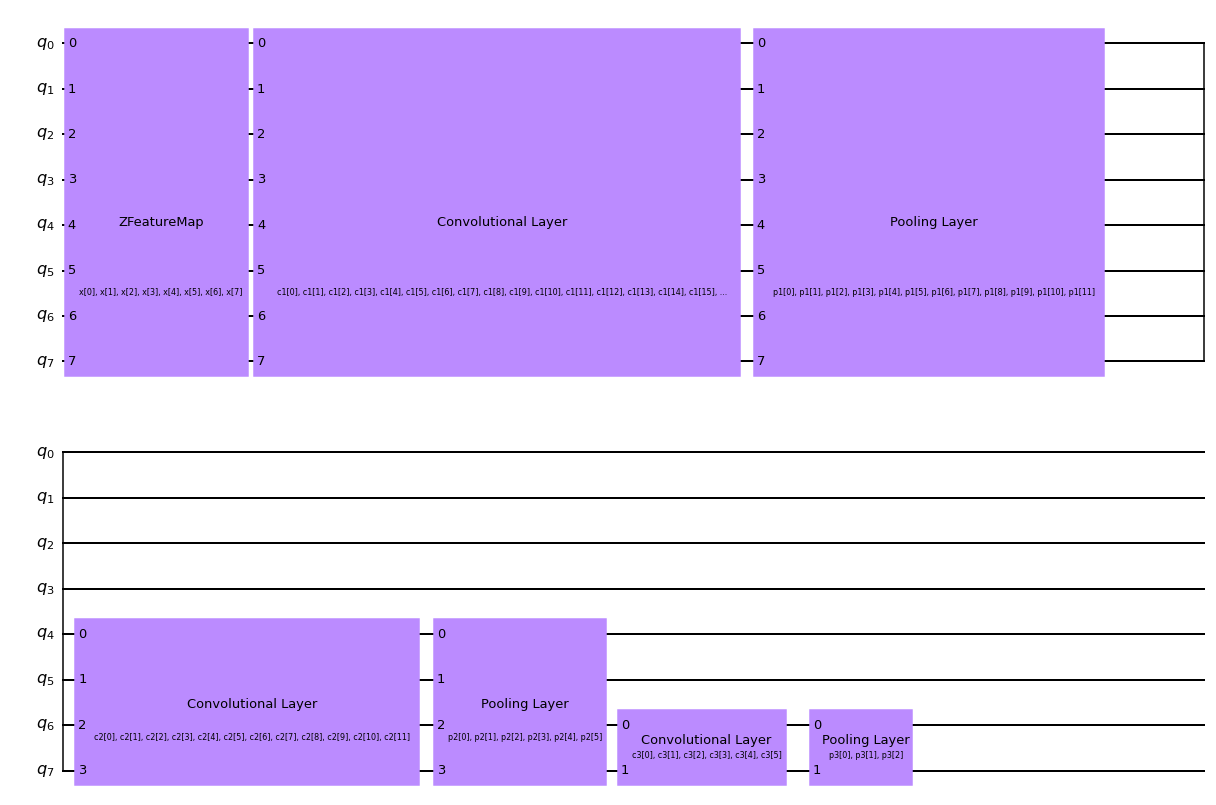

In [39]:
circuit.draw("mpl")

In [40]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [41]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph
)

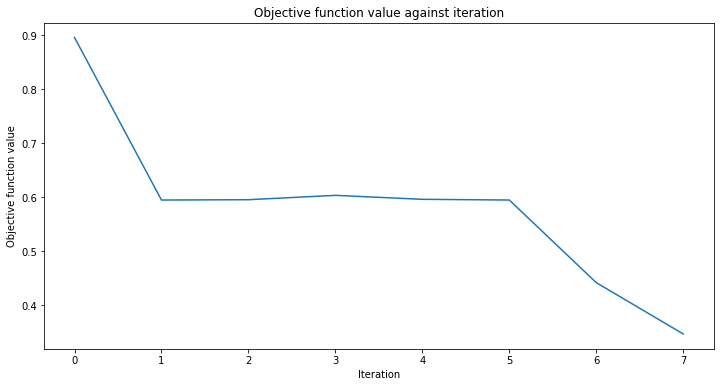

In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)
y = y.reshape(-1)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

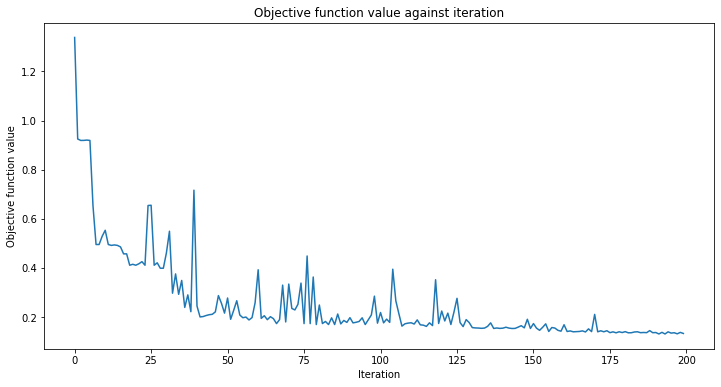

In [28]:
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)

# Save the plot as a PNG file
plt.savefig("objective_function_plot_pneumonia.png")

# Show the plot
plt.show()

In [29]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
y = y.reshape(-1)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 72.51%
